In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from glob import glob

In [2]:
# Base directory containing images and mask data
BASE_DIR = r"D:\understanding_cloud_organization"

# Paths to images and CSV file with labels (RLE encoded masks)
IMAGE_DIR = os.path.join(BASE_DIR, "train_images")  # Folder containing all images
MASK_CSV = os.path.join(BASE_DIR, "train.csv")  # CSV with image IDs and mask info

In [3]:
# Read CSV file containing run-length encoded (RLE) masks
df = pd.read_csv(MASK_CSV)

# Display first few rows
df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
# Get unique image filenames
image_ids = df["Image_Label"].unique()
print(f"Total unique images: {len(image_ids)}")

Total unique images: 22184


In [5]:
# Extract the image base names (excluding the label part) from the image_ids
image_bases = [img.split('_')[0] for img in image_ids]

# Get unique image base names
unique_image_bases = list(set(image_bases))
print(len(unique_image_bases))
# Perform the split on image bases (not individual labels)
train_bases, test_bases = train_test_split(unique_image_bases, test_size=0.2, random_state=42)
val_bases, test_bases = train_test_split(test_bases, test_size=0.5, random_state=42)

# Now, split the original image_ids into their respective sets (train, val, test) based on image bases
train_ids = [img for img in image_ids if img.split('_')[0] in train_bases]
val_ids = [img for img in image_ids if img.split('_')[0] in val_bases]
test_ids = [img for img in image_ids if img.split('_')[0] in test_bases]

print(f"Train Images: {len(train_ids)}")
print(f"Validation Images: {len(val_ids)}")
print(f"Test Images: {len(test_ids)}")

5546
Train Images: 17744
Validation Images: 2220
Test Images: 2220


In [7]:
# Define dataset directories
output_dirs = {
    "train": os.path.join(BASE_DIR, "train"),
    "val": os.path.join(BASE_DIR, "val"),
    "test": os.path.join(BASE_DIR, "test")
}

# Create directories for each split
for split, path in output_dirs.items():
    os.makedirs(os.path.join(path, "images"), exist_ok=True)
    os.makedirs(os.path.join(path, "masks"), exist_ok=True)

In [8]:
import os
import shutil

def move_files(image_list, split):
    for img_id in image_list:
        # Extract the image_id part before the label (e.g., "b4581bf" from "b4581bf.jpg_Sugar")
        img_base_id = img_id.split('_')[0]  # Assuming the image file has a '.jpg' extension
        src_image = os.path.join(IMAGE_DIR, img_base_id)  # Source path (image without label)
        
        # Make sure that the source image exists before moving it
        if os.path.exists(src_image):
            # Now, move the image into the appropriate folder for this split
            dst_image = os.path.join(output_dirs[split], "images", img_base_id)  # Destination path
            
            # Ensure the destination directory exists
            os.makedirs(os.path.dirname(dst_image), exist_ok=True)
            
            # Copy image to the destination directory
            shutil.copy(src_image, dst_image)
            print(f"Copied {img_base_id} to {split} folder.")
        else:
            print(f"Image {img_base_id} not found in source directory.")

# Assuming train_ids, val_ids, test_ids are lists of image_id with labels (e.g., "b4581bf.jpg_Sugar")
# Move images to respective folders
move_files(train_ids, "train")
move_files(val_ids, "val")
move_files(test_ids, "test")

print("Dataset successfully split and organized!")

Copied 002be4f.jpg to train folder.
Copied 002be4f.jpg to train folder.
Copied 002be4f.jpg to train folder.
Copied 002be4f.jpg to train folder.
Copied 0031ae9.jpg to train folder.
Copied 0031ae9.jpg to train folder.
Copied 0031ae9.jpg to train folder.
Copied 0031ae9.jpg to train folder.
Copied 003994e.jpg to train folder.
Copied 003994e.jpg to train folder.
Copied 003994e.jpg to train folder.
Copied 003994e.jpg to train folder.
Copied 00498ec.jpg to train folder.
Copied 00498ec.jpg to train folder.
Copied 00498ec.jpg to train folder.
Copied 00498ec.jpg to train folder.
Copied 006bf7c.jpg to train folder.
Copied 006bf7c.jpg to train folder.
Copied 006bf7c.jpg to train folder.
Copied 006bf7c.jpg to train folder.
Copied 006c5a6.jpg to train folder.
Copied 006c5a6.jpg to train folder.
Copied 006c5a6.jpg to train folder.
Copied 006c5a6.jpg to train folder.
Copied 008233e.jpg to train folder.
Copied 008233e.jpg to train folder.
Copied 008233e.jpg to train folder.
Copied 008233e.jpg to train 

In [9]:
# Save separate CSV files for each split
df_train = df[df["Image_Label"].isin(train_ids)]
df_val = df[df["Image_Label"].isin(val_ids)]
df_test = df[df["Image_Label"].isin(test_ids)]

df_train.to_csv(os.path.join(BASE_DIR, "train.csv"), index=False)
df_val.to_csv(os.path.join(BASE_DIR, "val.csv"), index=False)
df_test.to_csv(os.path.join(BASE_DIR, "test.csv"), index=False)

print("CSV files for train, validation, and test sets saved successfully!")

CSV files for train, validation, and test sets saved successfully!


In [10]:
import os
import numpy as np
import pandas as pd
import cv2

# Mapping of cloud labels to class IDs
cloud_types = { "Fish": 1, "Flower": 2, "Gravel": 3, "Sugar": 4 }

# Function to decode RLE to mask (using the provided function)
def rle_to_mask(rle_string, height, width):
    '''
    Convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    if rle_string == -1 or pd.isna(rle_string):  # Handle NaN or -1
        return np.zeros((height, width), dtype=np.uint8)
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        img = np.zeros(rows * cols, dtype=np.uint8)
        for start, length in rle_pairs:
            start -= 1
            img[start:start + length] = 255
        img = img.reshape(cols, rows)
        img = img.T
        return img

# Function to create and save combined class masks for each image
def save_combined_class_masks(df, image_list, split):
    mask_dir = os.path.join(BASE_DIR, split, "masks")
    os.makedirs(mask_dir, exist_ok=True)

    # Create a dictionary to group image IDs by base name (e.g., 002be4f.jpg)
    grouped_image_ids = {}
    for img_label in image_list:
        img_id = img_label.split('_')[0]  # Extract base image ID (e.g., 002be4f.jpg)
        if img_id not in grouped_image_ids:
            grouped_image_ids[img_id] = []
        grouped_image_ids[img_id].append(img_label)

    for img_id, labels in grouped_image_ids.items():
        # Create a blank image for storing the combined mask (single channel for grayscale)
        combined_mask = np.zeros((1400, 2100), dtype=np.uint8)

        for img_label in labels:
            # Filter rows where Image_Label matches the img_label
            img_masks = df[df["Image_Label"] == img_label]

            for _, row in img_masks.iterrows():
                # Skip if EncodedPixels is NaN or empty
                if pd.isna(row["EncodedPixels"]) or row["EncodedPixels"] == "":
                    continue  # Skip to the next mask for this image

                # Extract label from Image_Label by splitting the string
                label = img_label.split('_')[-1]
                class_label = cloud_types.get(label, 0)  # Get class ID from label, default to 0 if not found
                
                print(f"Processing image: {img_id}, label: {label}, class_label: {class_label}")  # Debug print
                
                # Decode RLE to class-specific mask
                class_mask = rle_to_mask(row["EncodedPixels"], 1400, 2100)  # Pass the image dimensions here

                if class_mask.max() == 0:
                    print(f"Warning: No mask data found for {img_id} with label {label}")  # Debug print if mask is empty

                # Add the class ID (not color) to the combined mask (only update where the mask is not zero)
                combined_mask[class_mask == 255] = class_label

        # Save the combined mask as a single image **once all labels are processed**
        name=img_id.split('.')[0]
        combined_mask_path = os.path.join(mask_dir, f"{name}.png")
        cv2.imwrite(combined_mask_path, combined_mask)
        print(f"Saved combined mask for {img_id}")

# Example of dataset splits (assuming the dataframes and image lists are defined elsewhere)
save_combined_class_masks(df_train, train_ids, "train")
save_combined_class_masks(df_val, val_ids, "val")
save_combined_class_masks(df_test, test_ids, "test")

print("Combined class masks saved!")

Processing image: 002be4f.jpg, label: Fish, class_label: 1
Processing image: 002be4f.jpg, label: Flower, class_label: 2
Processing image: 002be4f.jpg, label: Sugar, class_label: 4
Saved combined mask for 002be4f.jpg
Processing image: 0031ae9.jpg, label: Fish, class_label: 1
Processing image: 0031ae9.jpg, label: Flower, class_label: 2
Processing image: 0031ae9.jpg, label: Sugar, class_label: 4
Saved combined mask for 0031ae9.jpg
Processing image: 003994e.jpg, label: Fish, class_label: 1
Processing image: 003994e.jpg, label: Gravel, class_label: 3
Processing image: 003994e.jpg, label: Sugar, class_label: 4
Saved combined mask for 003994e.jpg
Processing image: 00498ec.jpg, label: Gravel, class_label: 3
Saved combined mask for 00498ec.jpg
Processing image: 006bf7c.jpg, label: Fish, class_label: 1
Processing image: 006bf7c.jpg, label: Sugar, class_label: 4
Saved combined mask for 006bf7c.jpg
Processing image: 006c5a6.jpg, label: Fish, class_label: 1
Processing image: 006c5a6.jpg, label: Sug

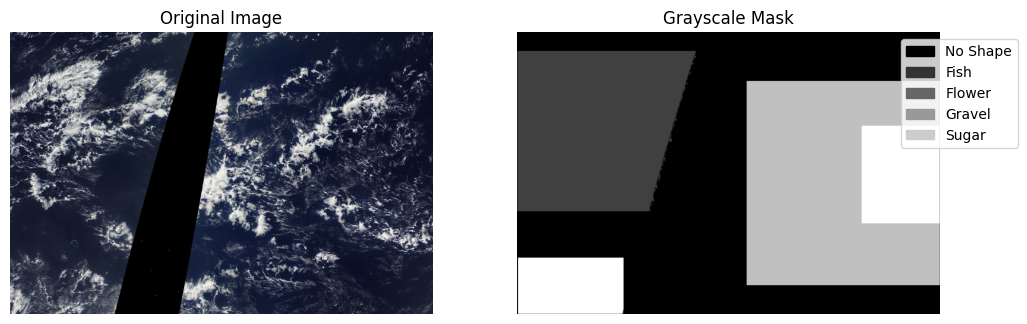

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.patches as mpatches  # For legend

# Define cloud types with associated grayscale values
cloud_types = {
    0: "No Shape",   # No cloud - black
    1: "Fish",       # Fish - light gray
    2: "Flower",     # Flower - medium gray
    3: "Gravel",     # Gravel - dark gray
    4: "Sugar"       # Sugar - lighter gray
}

def view_random_mask(image_dir, mask_dir):
    # Get a list of all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
    
    if not image_files:
        print("Error: No image files found in the directory.")
        return

    # Select a random image
    random_filename = random.choice(image_files)
    image_path = os.path.join(image_dir, random_filename)
    mask_path = os.path.join(mask_dir, random_filename.replace(".jpg", ".png").replace(".jpeg", ".png"))  # Ensure correct mask name

    # Load the original image
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

    # Load the mask (grayscale)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if images are loaded correctly
    if original is None:
        print(f"Error: Could not load image from {image_path}")
        return
    if mask is None:
        print(f"Error: Could not load mask from {mask_path}")
        return

    # Plot the results
    plt.figure(figsize=(12, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  
    plt.title("Grayscale Mask")
    plt.axis('off')

    legend_patches = [
        mpatches.Patch(color=str(0.0), label=f"No Shape"),      
        mpatches.Patch(color=str(0.2), label=f"Fish"),          
        mpatches.Patch(color=str(0.4), label=f"Flower"),        
        mpatches.Patch(color=str(0.6), label=f"Gravel"),        
        mpatches.Patch(color=str(0.8), label=f"Sugar")          
    ]

    # Add legend with color and labels
    plt.legend(handles=legend_patches, loc="upper right", bbox_to_anchor=(1.2, 1))

    plt.show()

# Example usage
image_dir = r"D:\understanding_cloud_organization\train\images"  
mask_dir = r"D:\understanding_cloud_organization\train\masks"    
view_random_mask(image_dir, mask_dir)